In [486]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from pandas.io.json import json_normalize
import urllib.parse as urlparse
%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (16, 12)
sns.set()

In [376]:
import requests

In [541]:
import re
def get_iso_country_code(name, default=None):
    if "," in name:
        parts = name.split(",")
        parts.reverse()
        name = " ".join(parts)
    name = name.strip()
    if name == "South Korea":
        name = "Republic of Korea"
    if name == "North Korea":
        name = "Democratic People's Republic of Korea"
    if name == "Czechia":
        name = "Czech Republic"
    if name == "United States" or name == "US":
        name = "United States of America"
    if default is None:
        default = re.sub(r"[\(\)\*]", "", name.lower().replace(" ", "_"))
    json = requests.get("https://restcountries.eu/rest/v2/name/%s" % urlparse.quote(name)).json()
    if isinstance(json, list):
        return json[0]["alpha2Code"]
    else:
        print("no country code found for %s, defaulting to %s" % (name, default))
        return default

In [542]:
factbook_json = requests.get("https://github.com/iancoleman/cia_world_factbook_api/blob/master/data/factbook.json?raw=true").json()

In [543]:
factbook = json_normalize([factbook_json["countries"][key]["data"] for key in factbook_json["countries"]])
factbook["iso_code"] = factbook["name"].apply(get_iso_country_code)
factbook.set_index("iso_code", inplace=True)

no country code found for World, defaulting to world
no country code found for Akrotiri, defaulting to akrotiri
no country code found for Arctic Ocean, defaulting to arctic_ocean
no country code found for Ashmore And Cartier Islands, defaulting to ashmore_and_cartier_islands
no country code found for Atlantic Ocean, defaulting to atlantic_ocean
no country code found for British Virgin Islands, defaulting to british_virgin_islands
no country code found for Clipperton Island, defaulting to clipperton_island
no country code found for Democratic Republic Of The Congo, defaulting to democratic_republic_of_the_congo
no country code found for Republic Of The Congo, defaulting to republic_of_the_congo
no country code found for Coral Sea Islands, defaulting to coral_sea_islands
no country code found for Dhekelia, defaulting to dhekelia
no country code found for Falkland Islands (Islas Malvinas), defaulting to falkland_islands_islas_malvinas
no country code found for Gaza Strip, defaulting to ga

In [544]:
factbook.head()

,name,introduction.background,geography.overview,geography.map_references,geography.area.total.value,geography.area.total.units,geography.area.land.value,geography.area.land.units,geography.area.water.value,geography.area.water.units,...,introduction.preliminary_statement,geography.area.rank_by_area_sq_km.value,geography.area.rank_by_area_sq_km.note,government.union_name.conventional_long_form,government.union_name.abbreviation,government.political_structure,government.capital.geographic_coordinates,government.member_states,economy.stock_of_broad_money.note,transportation.ports_and_terminals.major_ports
iso_code,,,,,,,,,,,,,,,,,,,,,
world,World,"Globally, the 20th century was marked by: (a) ...",The surface of the earth is approximately 70.9...,Physical Map of the World,510072000.0,sq km,148940000.0,sq km,361132000.0,sq km,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AF,Afghanistan,Ahmad Shah DURRANI unified the Pashtun tribes ...,NaN,Asia,652230.0,sq km,652230.0,sq km,0.0,sq km,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
akrotiri,Akrotiri,By terms of the 1960 Treaty of Establishment t...,NaN,Middle East,123.0,sq km,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AL,Albania,Albania declared its independence from the Ott...,NaN,Europe,28748.0,sq km,27398.0,sq km,1350.0,sq km,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DZ,Algeria,"After more than a century of rule by France, A...",NaN,Africa,2381740.0,sq km,2381740.0,sq km,0.0,sq km,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [545]:
covid_json = requests.get("https://pomber.github.io/covid19/timeseries.json").json()
covid_json_by_iso = {}
for key in covid_json.keys():
    covid_json_by_iso[get_iso_country_code(key)] = covid_json[key]

no country code found for Congo (Brazzaville), defaulting to congo_brazzaville
no country code found for Congo (Kinshasa), defaulting to congo_kinshasa
no country code found for Diamond Princess, defaulting to diamond_princess
no country code found for North Macedonia, defaulting to north_macedonia
no country code found for Taiwan*, defaulting to taiwan
no country code found for West Bank and Gaza, defaulting to west_bank_and_gaza
no country code found for MS Zaandam, defaulting to ms_zaandam


In [621]:
dates_of_lockdown = {
    'ES': pd.to_datetime("2020-03-14"),
    'US': pd.to_datetime("2020-03-21"),
    'CN': pd.to_datetime("2020-02-20"),
    'GB': pd.to_datetime("2020-03-23"),
    'IT': pd.to_datetime("2020-03-11"),
}
dates_of_first_onward_transmission = {
    'ES': pd.to_datetime("2020-02-29"),
    'US': pd.to_datetime("2020-01-30"),
    'CN': pd.to_datetime("2020-01-22"),
    'GB': pd.to_datetime("2020-02-28"),
    'IT': pd.to_datetime("2020-03-09"),
}

In [622]:
def df_for_country(country):
    df = pd.DataFrame(covid_json_by_iso[country])
    df["date"] = pd.to_datetime(df["date"])
    df["active"] = df.confirmed - df.deaths - df.recovered
    if country in dates_of_lockdown:
        df["lockdown"] = (df.date >= dates_of_lockdown[country]).astype(int)
    if country in dates_of_first_onward_transmission:
        df["onward_transmission"] = (df.date >= dates_of_first_onward_transmission[country]).astype(int)
    return df.set_index("date")

In [608]:
def df_for_countries(countries, align_field=None):
    df = None 
    for country in countries:
        dfc = df_for_country(country)
        if align_field:
            dfc = dfc[dfc[align_field] >= 1].reset_index()
        dfc = dfc.add_suffix("_%s" % country)
        if df is None: 
            df = dfc
        else:
            df = df.join(dfc)
    return df 

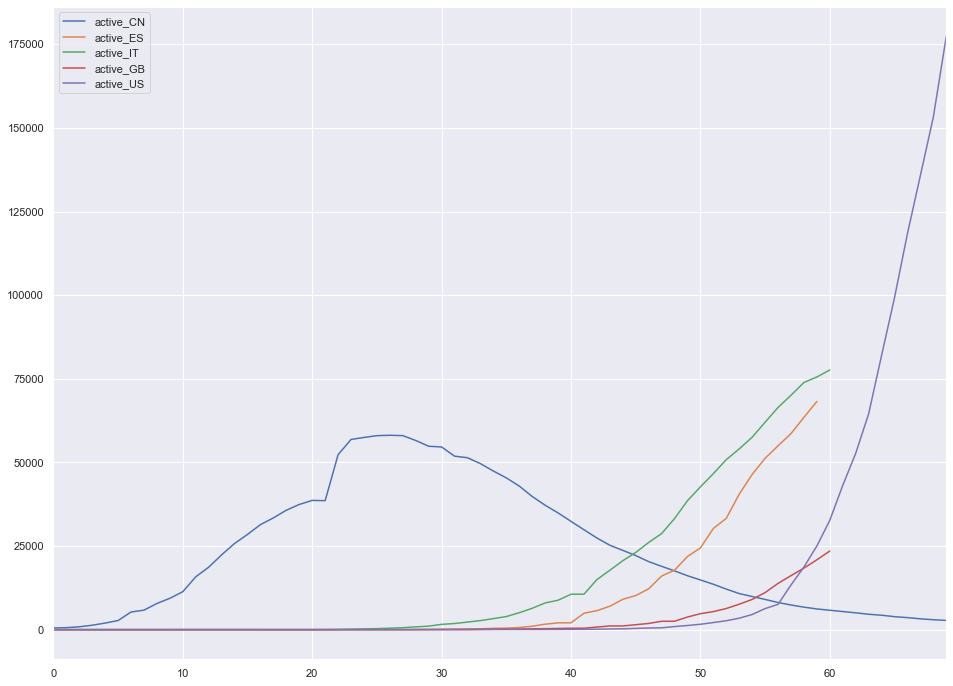

In [609]:
comparison = df_for_countries(["CN", "ES", "IT", "GB", "US"], align_field='confirmed')
active_cases_comparison = comparison.loc[:,comparison.columns.str.contains("active")]
active_cases_comparison.plot()

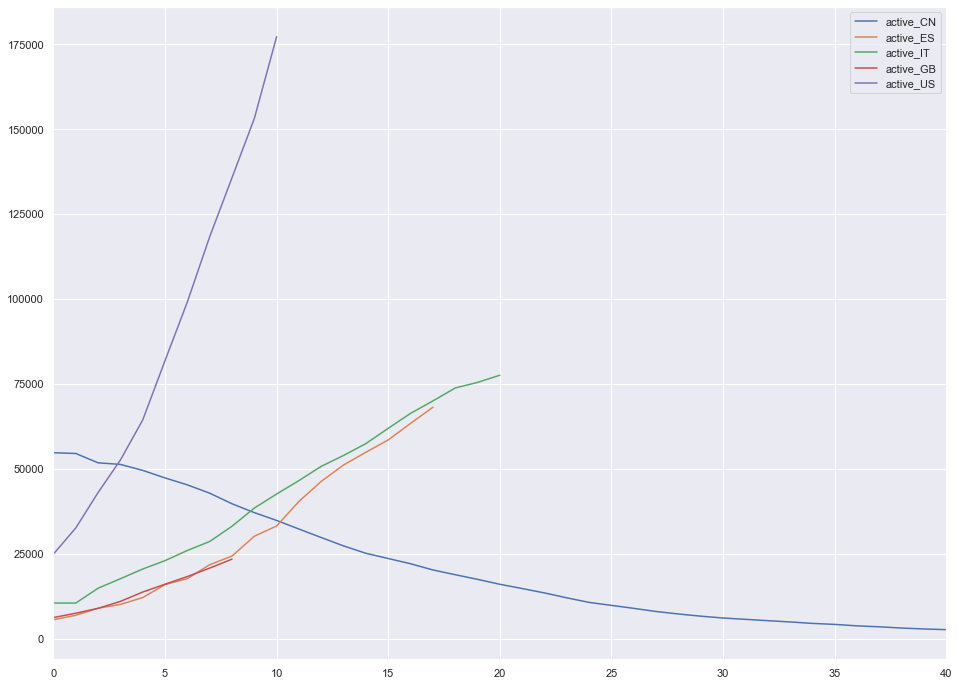

In [623]:
lockdown_comparison = df_for_countries(["CN", "ES", "IT", "GB", "US"], align_field='lockdown')
active_cases_lockdown_comparison = lockdown_comparison.loc[:,lockdown_comparison.columns.str.contains("active")]
active_cases_lockdown_comparison.plot()

In [627]:
deaths_comparison = comparison.loc[:,comparison.columns.str.contains("death")]

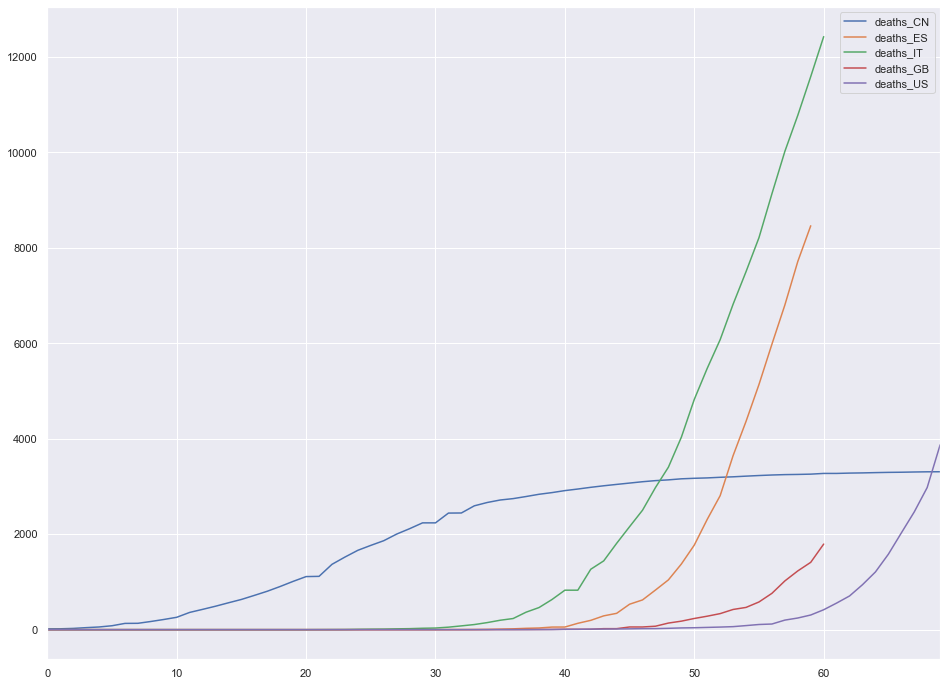

In [634]:
deaths_comparison.plot()

In [635]:
for key in ["ES", "IT", "CN", "GB", "US"]:
    comparison["population_%s" % key] = factbook.loc[key]["people.population.total"]
    comparison["active_cases_per_10k_pop_%s" % key] = comparison["active_%s" % key] / comparison["population_%s" % key] * 10000
    comparison["deaths_per_10k_pop_%s" % key] = comparison["deaths_%s" % key] / comparison["population_%s" % key] * 10000
    lockdown_comparison["population_%s" % key] = factbook.loc[key]["people.population.total"]
    lockdown_comparison["active_cases_per_10k_pop_%s" % key] = lockdown_comparison["active_%s" % key] / lockdown_comparison["population_%s" % key] * 10000
    lockdown_comparison["deaths_per_10k_pop_%s" % key] = lockdown_comparison["deaths_%s" % key] / lockdown_comparison["population_%s" % key] * 10000

In [630]:

active_cases_per_10k_comparison = comparison.loc[:,comparison.columns.str.contains("active_cases_per_10k")]

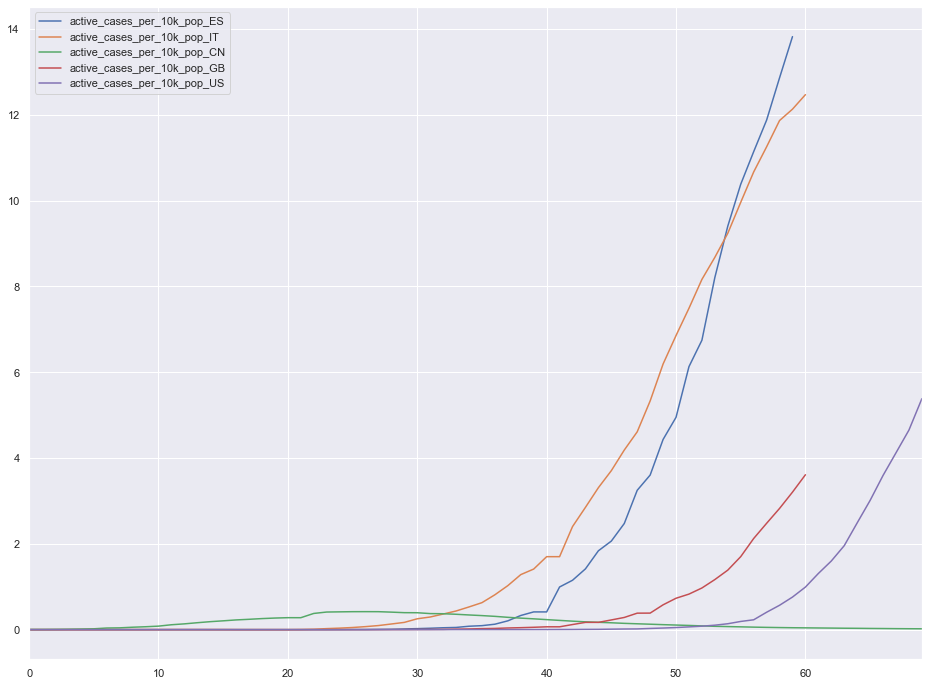

In [631]:
active_cases_per_10k_comparison.plot()

In [632]:
deaths_per_10k_comparison = comparison.loc[:,comparison.columns.str.contains("deaths_per_10k")]

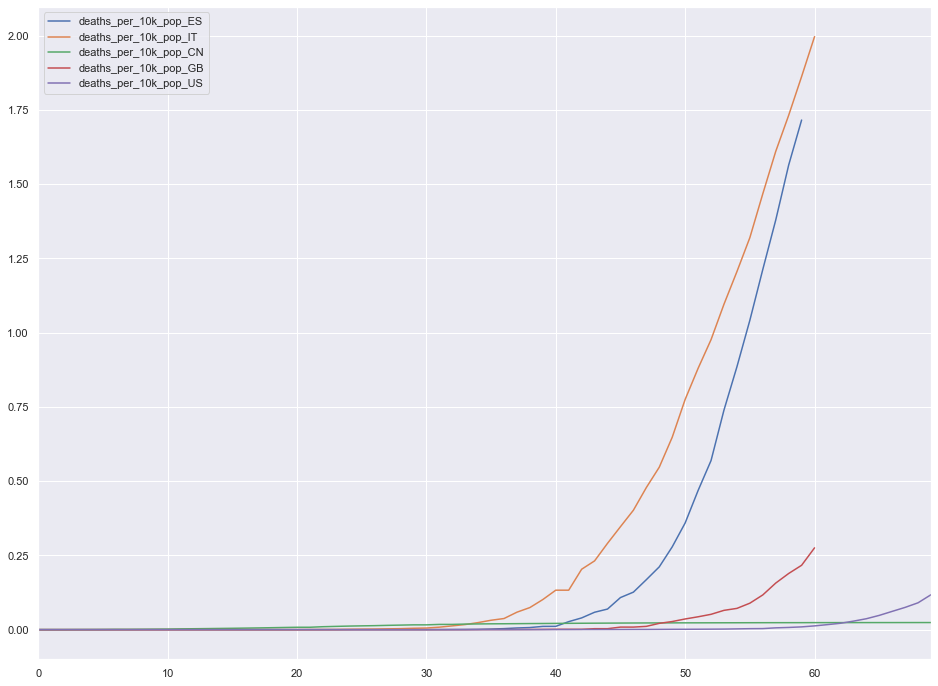

In [633]:
deaths_per_10k_comparison.plot()

In [636]:

active_cases_per_10k_lockdown_comparison = lockdown_comparison.loc[:,lockdown_comparison.columns.str.contains("active_cases_per_10k")]

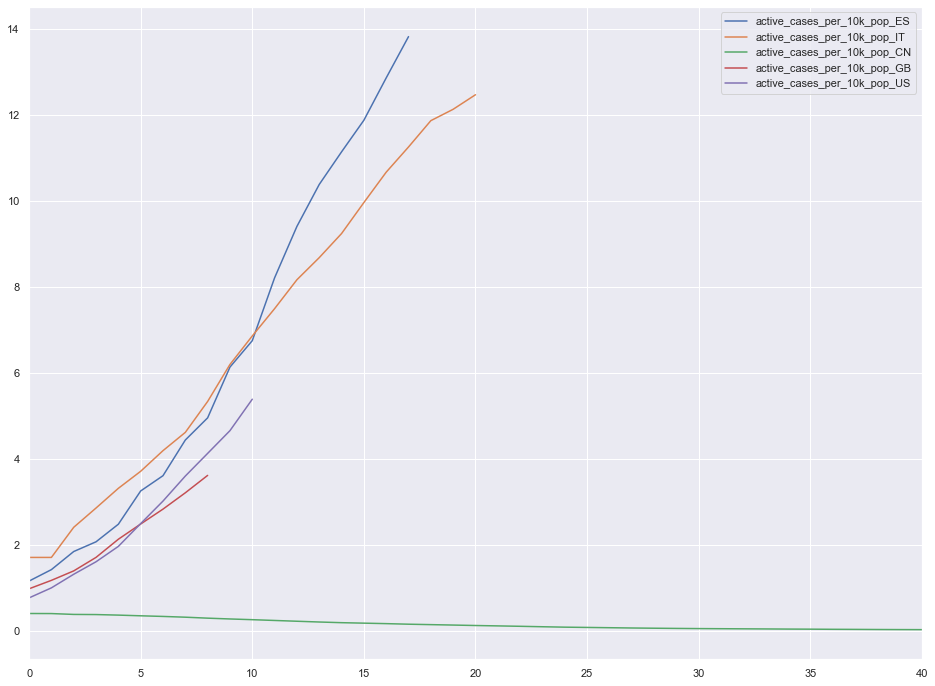

In [637]:
active_cases_per_10k_lockdown_comparison.plot()

In [638]:
deaths_per_10k_lockdown_comparison = lockdown_comparison.loc[:,lockdown_comparison.columns.str.contains("deaths_per_10k")]

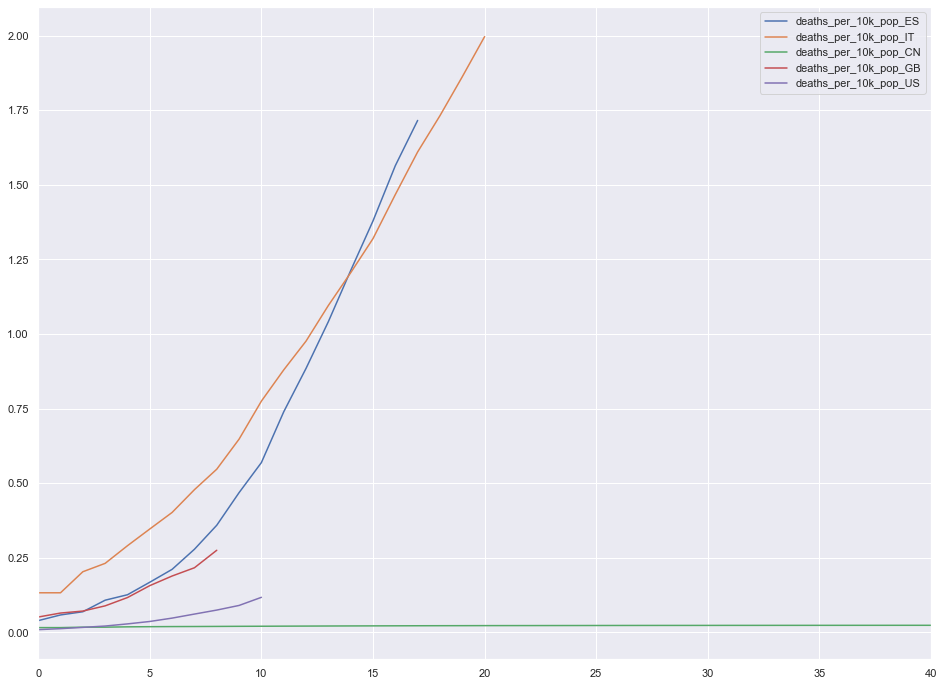

In [641]:
deaths_per_10k_lockdown_comparison.plot()